In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

C:\Users\Pablo\AppData\Local\Temp\ipykernel_5296\822149826.py:9: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [2]:
iris = sns.load_dataset('iris')

data = torch.tensor(iris.drop('species', axis=1).values, dtype=torch.float32)
labels = iris['species'].map({'setosa': 0, 'versicolor': 1, 'virginica': 2}).values
labels = torch.tensor(labels, dtype=torch.long) # torch long is used for classification labels

In [3]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42, stratify=labels)
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

batchsize = 64
train_dataset = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
test_dataset = DataLoader(test_dataset, batch_size=test_dataset.tensors[0].shape[0], shuffle=False) # load all

In [4]:
def create_model(l2_lambda, learning_rate):
    model = nn.Sequential(
        nn.Linear(4, 64),
        nn.ReLU(),
        nn.Linear(64, 64),
        nn.ReLU(),
        nn.Linear(64, 3)
    )
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=l2_lambda) # L2 regularization is applied via weight_decay
    return model, loss_fn, optimizer

In [5]:
# train the model
def train_model(model, loss_fn, optimizer, train_loader, test_loader, num_epochs=1000):
    train_acc = []
    test_acc = []
    losses = []
    
    for epoch in range(num_epochs):
        batch_losses = []
        batch_accuracies = []
        
        model.train()
        for X_batch, y_batch in train_loader:
            
            # forward pass
            y_pred_logits = model(X_batch)
            loss = loss_fn(y_pred_logits, y_batch)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # record batch loss and accuracy
            batch_losses.append(loss.item())
            batch_acc = (torch.argmax(y_pred_logits, dim=1) == y_batch).float().mean().item()
            batch_accuracies.append(batch_acc)

        train_acc.append(np.mean(batch_accuracies))
        losses.append(np.mean(batch_losses))
        
        # evaluate on test data
        model.eval()        
        X_test, y_test = test_loader.dataset.tensors
        y_pred_test_logits = model(X_test)
        y_pred_test = torch.argmax(y_pred_test_logits, dim=1)
        test_acc_item = (y_pred_test == y_test).float().mean().item()
        test_acc.append(test_acc_item)
    
    return train_acc, test_acc, losses

def smooth(x, k=5):
    # simple moving average to smooth the training loss curve for better visualization
    return np.convolve(x, np.ones(k)/k, mode='valid')

In [9]:
num_epochs = 1000
l2_lambda = np.linspace(0, 0.1, 11) # try different L2 regularization strengths
learning_rate = 0.01
accuracy_train = np.zeros((num_epochs, len(l2_lambda)))
accuracy_test = np.zeros((num_epochs, len(l2_lambda)))

for i, l2 in enumerate(l2_lambda):
    model, loss_fn, optimizer = create_model(l2_lambda=l2, learning_rate=learning_rate)
    train_acc, test_acc, _ = train_model(model, loss_fn, optimizer, train_dataset, test_dataset, num_epochs)
    accuracy_train[:, i] = train_acc
    accuracy_test[:, i] = test_acc

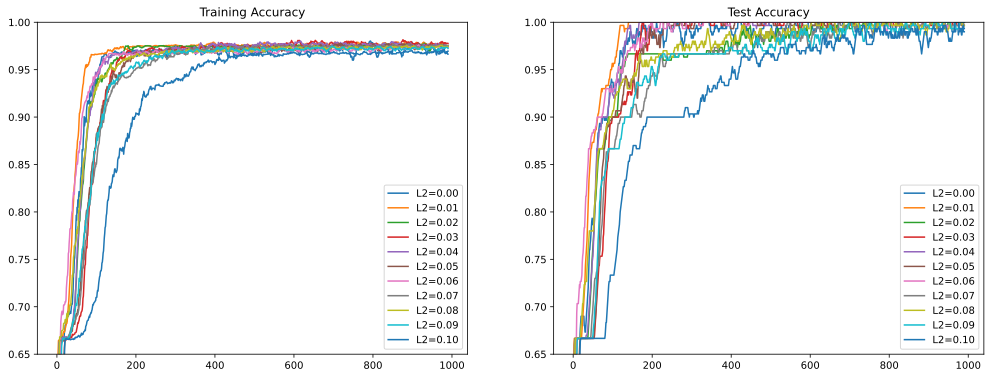

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(17, 6))

for i in range(len(l2_lambda)):
    ax[0].plot(smooth(accuracy_train[:, i], 10))
    ax[0].set_title('Training Accuracy')
    ax[0].set_ylim(0.65, 1)

    ax[1].plot(smooth(accuracy_test[:, i], 10))
    ax[1].set_title('Test Accuracy')
    ax[1].set_ylim(0.65, 1)

labels = [f'L2={l2:.2f}' for l2 in l2_lambda]
ax[0].legend(labels)
ax[1].legend(labels)

(0.65, 1.01)

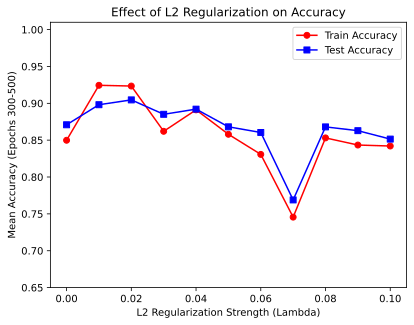

In [ ]:
epoch_range = [700, 1000]

mean_test_acc = np.mean(accuracy_test[epoch_range[0]:epoch_range[1], :], axis=0)
mean_train_acc = np.mean(accuracy_train[epoch_range[0]:epoch_range[1], :], axis=0)

plt.plot(l2_lambda, mean_train_acc, "ro-", label='Train Accuracy')
plt.plot(l2_lambda, mean_test_acc, "bs-", label='Test Accuracy')
plt.xlabel('L2 Regularization Strength (Lambda)')
plt.ylabel('Mean Accuracy (Epochs 700-1000)')
plt.title('Effect of L2 Regularization on Accuracy')
plt.legend()
plt.ylim(0.65, 1.01)